In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch 
from torchmetrics import Accuracy
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True)
        self.pool= nn.MaxPool2d(2,2)
        self.linear_layer1 = nn.Linear(in_features = 128 * 4 * 4, out_features = 16)
        self.linear_layer2 = nn.Linear(in_features = 16, out_features = 10)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.001)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)

        x = nn.functional.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)

        x = nn.functional.relu(self.linear_layer1(x))
        x = nn.functional.relu(self.linear_layer2(x))
        
        return x

    def accuracy_fn(self,y_true, y_pred):
        return Accuracy(task="multiclass", num_classes=10).to(device)
    
    def fit(self, train_loader, epochs):
        torch.manual_seed(42)
        for epoch in range(epochs):
            self.train()
            total_loss=0 
            
            for batch_idx, (images, labels) in enumerate(train_loader):
                            
                images = images.to(model.device)
                labels = labels.to(model.device)
                
                outputs = model(images)
                loss = self.loss_fn(outputs,labels)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

    def predict(self, X):
        X= X.to(self.device)
        self.eval()
        with torch.no_grad():
            logits = self.forward(X)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.35).int()
        return preds


In [29]:
batch_size=64

In [30]:
train_dataset = torchvision.datasets.CIFAR10(root="/dataset", train = True, transform= torchvision.transforms.ToTensor(), download = True)
train_loader= DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
test_dataset = torchvision.datasets.CIFAR10(root="/dataset", train = False, transform= torchvision.transforms.ToTensor(), download = True)
test_loader= DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
model= CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
model.to(model.device)
model.fit(train_loader, epochs=25)
torch.save(model.state_dict(), "model.pkl")

Epoch [1/25], Loss: 1.7143
Epoch [2/25], Loss: 1.2685
Epoch [3/25], Loss: 1.1015
Epoch [4/25], Loss: 1.0015
Epoch [5/25], Loss: 0.9323
Epoch [6/25], Loss: 0.8674
Epoch [7/25], Loss: 0.8140
Epoch [8/25], Loss: 0.7722
Epoch [9/25], Loss: 0.7286
Epoch [10/25], Loss: 0.6916
Epoch [11/25], Loss: 0.6531
Epoch [12/25], Loss: 0.6182
Epoch [13/25], Loss: 0.5858
Epoch [14/25], Loss: 0.5602
Epoch [15/25], Loss: 0.5318
Epoch [16/25], Loss: 0.5031
Epoch [17/25], Loss: 0.4765
Epoch [18/25], Loss: 0.4554
Epoch [19/25], Loss: 0.4321
Epoch [20/25], Loss: 0.4079
Epoch [21/25], Loss: 0.3893
Epoch [22/25], Loss: 0.3692
Epoch [23/25], Loss: 0.3504
Epoch [24/25], Loss: 0.3399
Epoch [25/25], Loss: 0.3165


In [33]:
model_instance = CNN()
model_instance.load_state_dict(torch.load("model.pkl"))
model_instance.to(model_instance.device)

<ipython-input-33-88b9aa352c17>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_instance.load_state_dict(torch.load("model.pkl"))


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_layer1): Linear(in_features=2048, out_features=16, bias=True)
  (linear_layer2): Linear(in_features=16, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [34]:
model_instance.eval()
test_loss = 0.0
test_correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(model_instance.device), labels.to(model_instance.device)

        outputs = model(images)
        loss = model_instance.loss_fn(outputs, labels)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        test_correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")


Test Loss: 1.1325, Test Accuracy: 70.79%


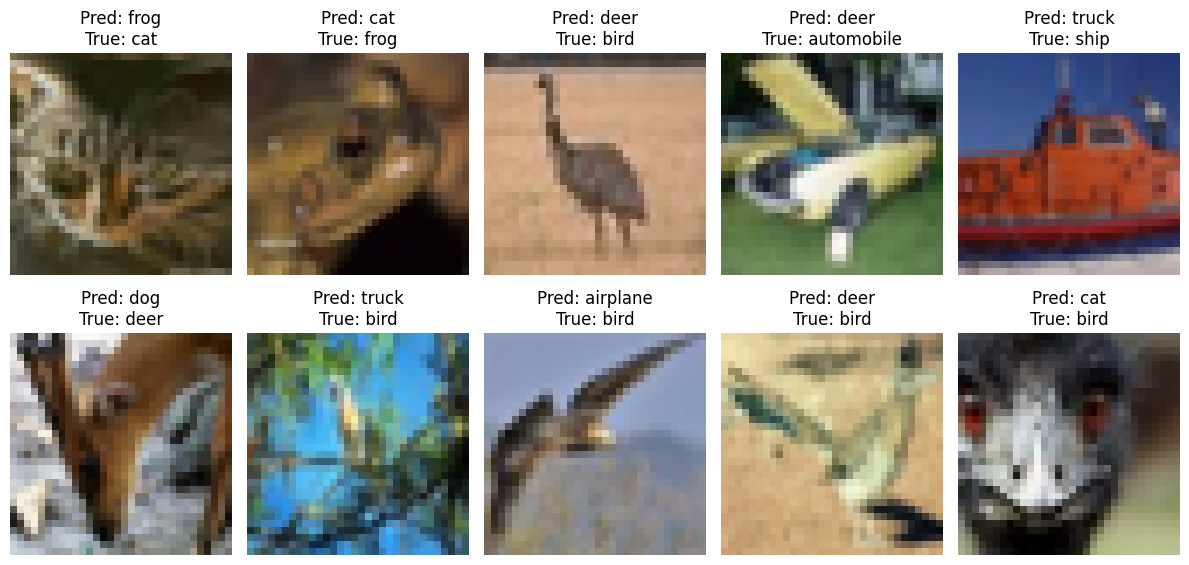

In [35]:
import matplotlib.pyplot as plt
import torchvision

misclassified = []
classes = test_loader.dataset.classes  # CIFAR-10 labels

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(model.device), labels.to(model.device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        mismatches = preds != labels
        for img, pred, label in zip(images[mismatches], preds[mismatches], labels[mismatches]):
            misclassified.append((img.cpu(), pred.cpu(), label.cpu()))
        if len(misclassified) >= 10:
            break  # Just show first 10

# Plotting
plt.figure(figsize=(12, 6))
for i, (img, pred, label) in enumerate(misclassified[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(torchvision.utils.make_grid(img).permute(1, 2, 0))
    plt.title(f"Pred: {classes[pred]}\nTrue: {classes[label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
